# Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from config_manager import ConfigManager
from data_access import DataAccess

schema = ConfigManager.get_config('clustersConfig.schema')
table = ConfigManager.get_config('clustersConfig.table')
indexCol = ConfigManager.get_config('clustersConfig.index_col')

bikes = DataAccess().select_to_df(f"SELECT * FROM {schema}.{table} LIMIT 1000")

bikes

Connecting to the mysql database...
Connected to localhost:datasets.


,_id,bikeid,start_time,duration_minutes,start_station_name,end_station_name,start_latitude,start_longitude,end_latitude,end_longitude
0,1,546,2016-01-20 12:12:37,7,Palmer Auditorium,3rd & West,30.25971,-97.75346,30.26780,-97.75189
1,2,80,2016-02-13 13:23:23,24,3rd & West,East 6th & Pedernales St.,30.26780,-97.75189,30.25895,-97.71475
2,3,362,2015-07-18 14:12:00,24,UT West Mall @ Guadalupe,Rainey St @ Cummings,30.28576,-97.74181,30.25579,-97.73982
3,4,220,2016-10-10 06:51:37,8,Convention Center / 4th St. @ MetroRail,Barton Springs & Riverside,30.26483,-97.73900,30.25870,-97.74872
4,5,877,2015-11-25 05:12:24,6,Barton Springs & Riverside,Pfluger Bridge @ W 2nd Street,30.25870,-97.74872,30.26717,-97.75484
...,...,...,...,...,...,...,...,...,...,...
295,296,789,2017-02-26 17:28:48,26,Barton Springs Pool,Pfluger Bridge @ W 2nd Street,30.26452,-97.77120,30.26717,-97.75484
296,297,663,2014-03-13 12:12:00,20,Long Center @ South 1st & Riverside,Waller & 6th St.,30.25941,-97.74971,30.26461,-97.73049
297,298,288,2016-11-02 17:47:08,66,Guadalupe & 21st,Guadalupe & 21st,30.28395,-97.74198,30.28395,-97.74198
298,299,209,2016-01-12 15:37:38,64,5th & Bowie,5th & Bowie,30.26960,-97.75332,30.26960,-97.75332


## Query workload

In [3]:
from jaccard_workload_approximator import JaccardWorkloadApproximator

workload_approximator = JaccardWorkloadApproximator()

workload = workload_approximator.run(20)
workloadResults = workload_approximator.results

============ starting iteration 1   ============
Processing query:
SELECT _id FROM datasets.austin_bikes_100 WHERE start_longitude BETWEEN -97.74716931081274 AND -97.73753224243669 AND start_latitude BETWEEN 30.25712359258462 AND 30.28055982480033 AND end_station_name IN ('MoPac Pedestrian Bridge @ Veterans Drive' , 'Capitol Station / Congress & 11th' , '5th & San Marcos' , 'State Capitol Visitors Garage @ San Jacinto & 12th' , 'Boardwalk West' , 'Rainey St @ Cummings' , 'Bullock Museum @ Congress & MLK' , 'City Hall / Lavaca & 2nd' , 'Guadalupe & 6th' , 'East 6th & Pedernales St.' , 'Convention Center / 4th St. @ MetroRail' , 'Capital Metro HQ - East 5th at Broadway' , '8th & Congress' , 'East 2nd & Pedernales')
Processing query:
SELECT _id FROM datasets.austin_bikes_100 WHERE bikeid IN ('166' , '193' , '178' , '142' , '362' , '421' , '854' , '371' , '110' , '572' , '999' , '442' , '930' , '805' , '122' , '465' , '775' , '984' , '299' , '360' , '185' , '329' , '696' , '829' , '348' , 

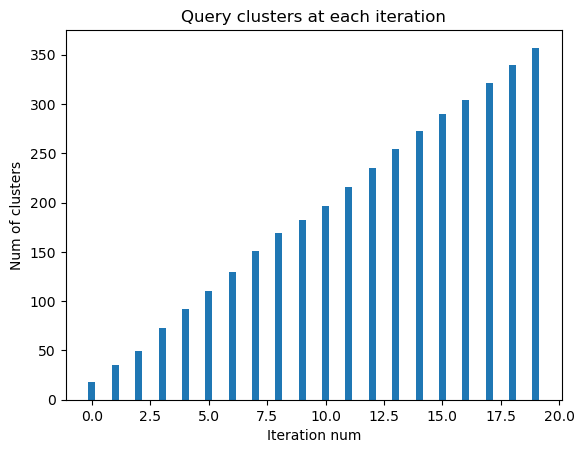

In [4]:
import matplotlib.pyplot as plt
from graphs_manager import GraphsManager
from consts import GraphNames

clustersGraph = GraphsManager.get_graph(GraphNames.CLUSTERS)

plt.bar(clustersGraph.get_x_axis(), clustersGraph.get_y_axis(), 0.3)
plt.xlabel("Iteration num")
plt.ylabel("Num of clusters")
plt.title("Query clusters at each iteration")
plt.show()

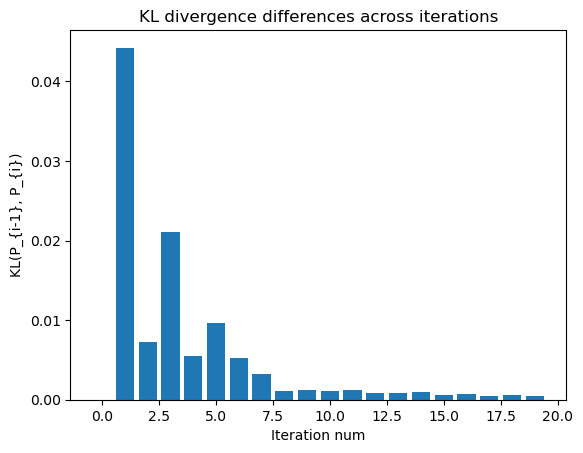

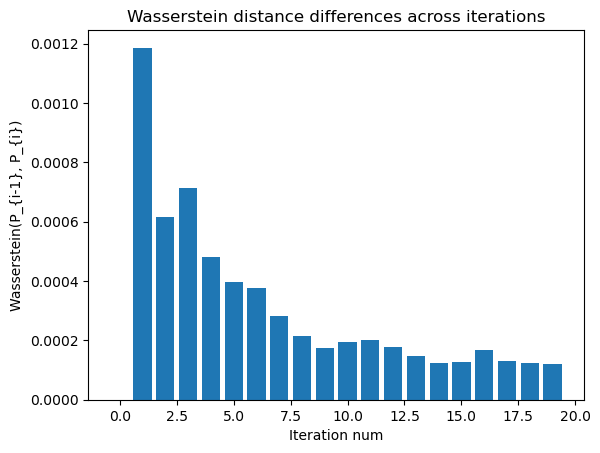

In [5]:
import matplotlib.pyplot as plt
from graphs_manager import GraphsManager
from consts import GraphNames
from scipy.special import rel_entr
from scipy.stats import wasserstein_distance

kl_divergence = lambda p,q: sum(rel_entr(p,q))

distributionsGraph = GraphsManager.get_graph(GraphNames.DISTRIBUTIONS)
distributions = distributionsGraph.get_y_axis()
KL_diff = [0]
Wasser_diff = [0]

for i in range(1, len(distributionsGraph.get_x_axis())):
    KL_diff.append(kl_divergence(distributions[i-1], distributions[i]))
    Wasser_diff.append(wasserstein_distance(distributions[i-1], distributions[i]))

plt.figure(1)
plt.bar(distributionsGraph.get_x_axis(), KL_diff, 0.8)
plt.xlabel("Iteration num")
plt.ylabel("KL(P_{i-1}, P_{i})")
plt.title("KL divergence differences across iterations")

plt.figure(2)
plt.bar(distributionsGraph.get_x_axis(), Wasser_diff, 0.8)
plt.xlabel("Iteration num")
plt.ylabel("Wasserstein(P_{i-1}, P_{i})")
plt.title("Wasserstein distance differences across iterations")

plt.show()

## Sample

In [6]:
from saqp_manager import SaqpManager
import pandas as pd
from checkpoint_manager import CheckpointManager
from consts import CheckpointNames

weights_from_cache = CheckpointManager.load(CheckpointNames.WEIGHTS)
clusters_from_cache = CheckpointManager.load(CheckpointNames.CLUSTERS)

k = 20
saqp_manager = SaqpManager([query['result'] for query in clusters_from_cache],
                           [query['frequency'] for query in clusters_from_cache],
                           weights_from_cache)
sample = saqp_manager.get_sample(k)
df = pd.DataFrame(sample)
df

300it [00:02, 108.24it/s]


finished weights calculation!
Saving checkpoint weights.pkl to: [./checkpoints/5]
Start running algorithm with budget: 20
Start running LazyGreedy with type UC
Starting algorithm initialization


300it [00:01, 214.82it/s]


Algorithm initialization done after: 1434.33 ms
============ starting iteration 1   ============
Calculating maximal p took: 0.00 ms, covered: 1
Added: [263] to S, new gain: [0.4057], remaining budget: [19]
Finished updating S, update took: 16.84 ms
iteration took: 16.84 ms
============ starting iteration 2   ============
Setting all p.isCurrent to False took: 0.00 ms
Calculating maximal p took: 0.00 ms, covered: 1
Calculating delta[93] took: 16.42 ms
Calculating maximal p took: 0.00 ms, covered: 2
Calculating delta[290] took: 16.40 ms
Calculating maximal p took: 0.00 ms, covered: 3
Calculating delta[264] took: 17.74 ms
Calculating maximal p took: 0.00 ms, covered: 4
Calculating delta[69] took: 16.75 ms
Calculating maximal p took: 0.00 ms, covered: 5
Calculating delta[239] took: 7.06 ms
Calculating maximal p took: 0.00 ms, covered: 6
Calculating delta[104] took: 19.31 ms
Calculating maximal p took: 0.00 ms, covered: 7
Calculating delta[56] took: 0.00 ms
Calculating maximal p took: 0.00

,_id,bikeid,start_time,duration_minutes,start_station_name,end_station_name,start_latitude,start_longitude,end_latitude,end_longitude
0,264,35,2014-04-23 21:12:00,8,2nd & Congress,Convention Center / 4th St. @ MetroRail,30.264080,-97.743550,30.264830,-97.739000
1,274,805,2014-03-14 12:12:00,11,Long Center @ South 1st & Riverside,City Hall / Lavaca & 2nd,30.259410,-97.749710,30.264760,-97.746780
2,39,52,2017-07-19 15:33:06,5,Capitol Station / Congress & 11th,4th & Congress,30.272600,-97.741270,30.266340,-97.743780
3,299,209,2016-01-12 15:37:38,64,5th & Bowie,5th & Bowie,30.269600,-97.753320,30.269600,-97.753320
4,103,213,2017-05-25 15:23:20,15,Davis at Rainey Street,2nd & Congress,30.260190,-97.738450,30.264080,-97.743550
5,127,442,2016-08-10 13:55:42,3,Riverside @ S. Lamar,Pfluger Bridge @ W 2nd Street,30.264460,-97.756650,30.267170,-97.754840
6,100,693,2015-10-16 09:12:27,7,East 11th St. at Victory Grill,Trinity & 6th Street,30.268960,-97.728430,30.267350,-97.739330
7,148,399,2014-07-12 09:12:00,44,Pfluger Bridge @ W 2nd Street,Rainey St @ Cummings,30.267170,-97.754840,30.255790,-97.739820
8,147,863,2017-06-29 21:23:12,5,City Hall / Lavaca & 2nd,3rd & West,30.264760,-97.746780,30.267800,-97.751890
9,257,36,2014-09-14 16:12:00,22,Capitol Station / Congress & 11th,Capitol Station / Congress & 11th,30.272600,-97.741270,30.272600,-97.741270


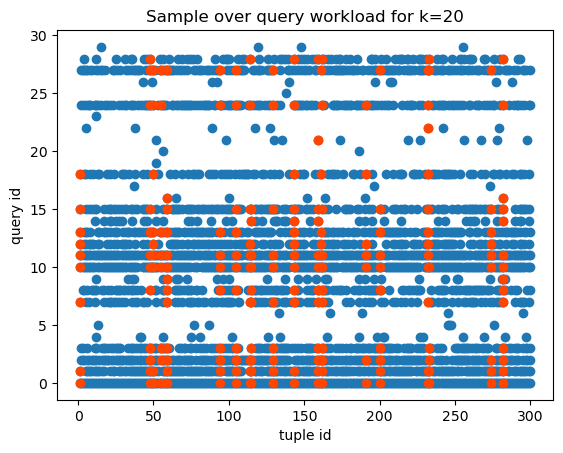

In [22]:
import matplotlib.pyplot as plt
import random

DEFAULT_DOT_SIZE = 5
NUM_OF_QUERIES_TO_PLOT = 30

flat = lambda l: [item for sublist in l for item in sublist]
queries_indices = random.sample([*range(len(workload))], 10)
y = flat([[i] * len(workload[i]['result']) for i in range(NUM_OF_QUERIES_TO_PLOT)])
x = flat([workload[i]['result'] for i in range(NUM_OF_QUERIES_TO_PLOT)])

sampleIds = [tup[indexCol] for tup in sample]
x_sample = [t for t in x if t in set(sampleIds)]
y_sample = [y[i] for i in range(len(y)) if x[i] in set(sampleIds)]
# sizes = flat([[DEFAULT_DOT_SIZE * workload[i]['frequency']] * len(workload[i]['result']) for i in range(NUM_OF_QUERIES_TO_PLOT)])

plt.scatter(x, y)
plt.scatter(x_sample, y_sample, color='#FF4500')
plt.title(f"Sample over query workload for k={k}")
plt.xlabel("tuple id")
plt.ylabel("query id")
plt.show()

## Score on Train vs Test set

In [23]:
maxTestIters = ConfigManager.get_config('testConfig.max_test_iters')
testWorkload = workload_approximator.run(maxTestIters)
testWorkloadResults = workload_approximator.results

testQueryResults = [query['result'] for query in testWorkload]
testQueryWeights = [query['frequency'] for query in testWorkload]
test_saqp_manager = SaqpManager(testQueryResults, testQueryWeights)

test_score_func = SaqpManager.get_test_score_func([query['result'] for query in testWorkload],
                                                  [query['frequency'] for query in testWorkload])
train_score_func = SaqpManager.get_test_score_func([query['result'] for query in workload],
                                                   [query['frequency'] for query in workload])
# train_score_func = saqp_manager.saqpParAdapter.get_gain_function()

============ starting iteration 1   ============
Processing query:
SELECT _id FROM datasets.austin_bikes_100 WHERE bikeid IN ('110' , '955' , '266' , '575' , '206' , '890' , '166' , '528' , '203' , '62' , '384' , '219' , '993' , '593' , '863' , '896' , '281' , '190' , '79' , '35' , '465' , '445' , '80' , '572' , '938' , '230' , '188' , '958' , '860' , '907' , '36' , '352' , '513' , '410' , '160' , '984' , '209' , '55' , '897' , '54' , '716' , '937' , '302' , '670' , '362' , '202' , '299' , '460' , '875' , '348' , '95' , '878' , '832' , '89' , '693' , '461' , '432' , '827' , '412' , '406' , '588' , '1000' , '386' , '247' , '522' , '728' , '78' , '829' , '282' , '185' , '416' , '979' , '511' , '306' , '198' , '625' , '385' , '898' , '303' , '864' , '961' , '998' , '805' , '382' , '464' , '775' , '554' , '869' , '153' , '772' , '232' , '284' , '540' , '417' , '983' , '854' , '178' , '49' , '370' , '320' , '329' , '550' , '220' , '865' , '150' , '175' , '765' , '164' , '870' , '576' , '142

300it [00:02, 111.82it/s]

finished weights calculation!


In [24]:
k_values = [*range(10, 60, 10)]

print('starting train samples')
train_samples_to_k = [saqp_manager.get_sample(k, print_debug_logs=False) for k in k_values]

print('starting test samples')
optimum_samples_to_k = [test_saqp_manager.get_sample(k, print_debug_logs=False) for k in k_values]

starting train samples
Start running algorithm with budget: 10
PAR algorithm took: 11945.82 ms
Start running algorithm with budget: 20
PAR algorithm took: 29420.38 ms
Start running algorithm with budget: 30
PAR algorithm took: 49420.86 ms
Start running algorithm with budget: 40
PAR algorithm took: 65110.13 ms
Start running algorithm with budget: 50
PAR algorithm took: 71122.07 ms
starting test samples
Start running algorithm with budget: 10
PAR algorithm took: 12130.09 ms
Start running algorithm with budget: 20
PAR algorithm took: 28889.20 ms
Start running algorithm with budget: 30
PAR algorithm took: 41738.96 ms
Start running algorithm with budget: 40
PAR algorithm took: 62253.97 ms
Start running algorithm with budget: 50
PAR algorithm took: 109843.28 ms


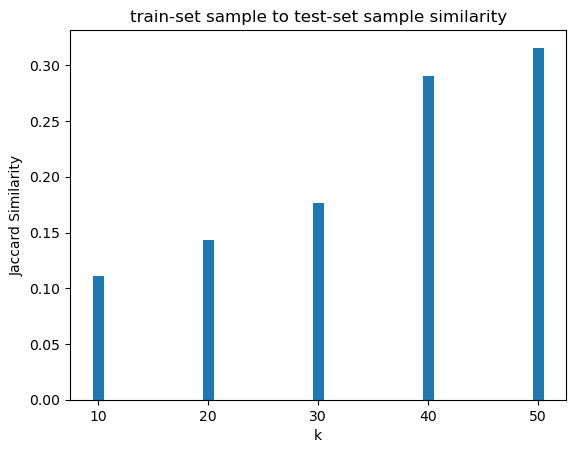

In [25]:
similarities = [workload_approximator.similarity([obj[indexCol] for obj in optimum_samples_to_k[i]],
                                                 [obj[indexCol] for obj in train_samples_to_k[i]]) for i in
                range(len(k_values))]

plt.bar(k_values, similarities, 1)

plt.xlabel("k")
plt.ylabel("Jaccard Similarity")
plt.title("train-set sample to test-set sample similarity")
plt.show()

In [ ]:
train_scores = [train_score_func(S) for S in train_samples_to_k]
test_scores = [test_score_func(S) for S in train_samples_to_k]
optimum_scores = [test_score_func(S) for S in optimum_samples_to_k]

plt.bar([t - 1 for t in k_values], train_scores, 1, label='Train Scores')
plt.bar(k_values, test_scores, 1, label='Test Scores')
plt.bar([t + 1 for t in k_values], optimum_scores, 1, label='Optimum Scores')

plt.xlabel("k")
plt.ylabel("Scores")
plt.title("Sample Scores to k")
plt.legend()
plt.show()  # RUN AGAIN MULTIPLE TIMES and normalize score

In [ ]:
iters = [*range(maxTestIters)]

trainResultsAndWeights = [
    ([query['result'] for query in workloadResults[i]],
     [query['frequency'] for query in workloadResults[i]])
    for i in iters]

testResultsAndWeights = [
    ([query['result'] for query in testWorkloadResults[i]],
     [query['frequency'] for query in workloadResults[i]])
    for i in iters]

print('starting train samples')
samples = [SaqpManager(trainResultsAndWeights[i][0], trainResultsAndWeights[i][1]).get_sample(k, print_debug_logs=False)
           for i in iters]

print('starting test samples')
optimum_samples = [
    SaqpManager(testResultsAndWeights[i][0], testResultsAndWeights[i][1]).get_sample(k, print_debug_logs=False) for i in
    iters]

In [ ]:
train_scores = [train_score_func(S) for S in samples]
test_scores = [test_score_func(S) for S in samples]
optimum_scores = [test_score_func(S) for S in optimum_samples]

plt.bar([t - 0.2 for t in iters], train_scores, 0.2, label='Train Scores')
plt.bar(iters, test_scores, 0.2, label='Test Scores')
plt.bar([t + 0.2 for t in iters], optimum_scores, 0.2, label='Optimum Scores')

plt.xlabel("iterations")
plt.ylabel("Scores")
plt.title("Sample Scores to iterations")
plt.legend()
plt.show()

In [ ]:
# =========================================================

In [18]:
random_sample = DataAccess().select(f"SELECT * FROM {schema}.{table} ORDER BY RANDOM() LIMIT {saqp_manager.k}")
df2 = pd.DataFrame(random_sample)

In [19]:
import kmedoids
import numpy as np
from scipy.spatial.distance import pdist, squareform

population = saqp_manager.saqpParAdapter.get_population()


def np_dist(t1, t2):
    keys = [*population[0].keys()]
    t1_dict = {}
    t2_dict = {}
    for i in range(len(t1)):
        t1_dict[keys[i]] = t1[i]
        t2_dict[keys[i]] = t2[i]
    return saqp_manager.saqpParAdapter._dist(t1_dict, t2_dict)


T = np.array([[*d.values()] for d in saqp_manager.saqpParAdapter.get_population()])
distmatrix = squareform(pdist(T, np_dist))
km = kmedoids.fasterpam(distmatrix, saqp_manager.k)
kmedoids_sample = [population[i] for i in list(km.medoids)]
df3 = pd.DataFrame(kmedoids_sample)

In [16]:
score_func = saqp_manager.saqpParAdapter.get_gain_function()
print(f"Sample score for our sample: {score_func(sample)}")

numRandomTrials = 100
random_score = sum(
    [score_func(DataAccess().select(f"SELECT * FROM {schema}.{table} ORDER BY RANDOM() LIMIT {saqp_manager.k}")) for i
     in range(numRandomTrials)]) / numRandomTrials

# TODO print min and max for random
# TODO change kmedoids by multiplying the points by their weight
# TODO add a graph showing sample scores w.r.t to k (sample size) (test queries or train queries?)
# TODO add graphs showing sample score (w.r.t to train and test) of our sample and runtime w.r.t to num of queries in train set (fixed sample size) - do this after KL


print(f"Sample score for random sample: {random_score}")
print(f"Sample score for kmedoids sample: {score_func(kmedoids_sample)}")  # TODO: look at this more closely again
# TODO add random greedy that in each batch of queries chooses the x tuple with the most cumulative weight until S is full - DO THIS LATER

Sample score for our sample: 23453.82599045498760865315797
Sample score for random sample: 22426.63794223579797109131892
Sample score for kmedoids sample: 22408.59721315035007074243711


In [ ]:
# TODO partition queries to train-test

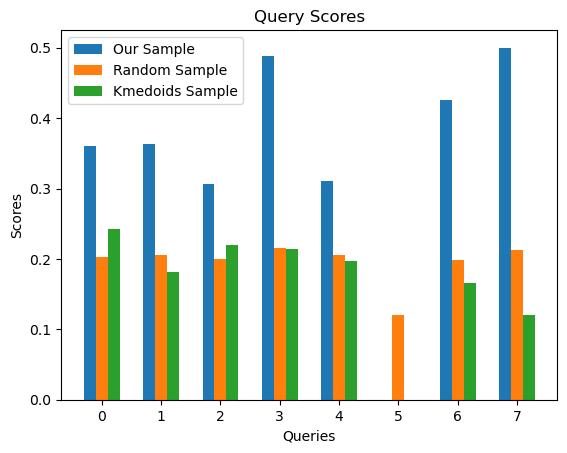

In [119]:
import pandasql as ps
import matplotlib.pyplot as plt

dataAccess = DataAccess()
queries = [q['sql'][0].replace("_id", "*") for q in workload]
x = [*range(len(queries))]

sampleY = []
randomY = []
kmedoidsY = []
for query in queries:
    sample_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "df"))
    kmedoids_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "df3"))

    sampleY += [saqp_manager.saqpParAdapter.query_result_score(sample_query_df.to_dict('records'),
                                                               dataAccess.select_to_df(query).to_dict('records'))]
    random_dfs = [DataAccess().select_to_df(f"SELECT * FROM {schema}.{table} ORDER BY RANDOM() LIMIT {saqp_manager.k}")
                  for i in range(numRandomTrials)]
    random_scores = []
    for random_df in random_dfs:
        random_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "random_df"))
        random_scores += [saqp_manager.saqpParAdapter.query_result_score(random_query_df.to_dict('records'),
                                                                         dataAccess.select_to_df(query).to_dict(
                                                                             'records'))]
    randomY += [(sum(random_scores) / numRandomTrials)]
    kmedoidsY += [saqp_manager.saqpParAdapter.query_result_score(kmedoids_query_df.to_dict('records'),
                                                                 dataAccess.select_to_df(query).to_dict('records'))]

plt.bar([t - 0.2 for t in x], sampleY, 0.2, label='Our Sample')
plt.bar([t for t in x], randomY, 0.2, label='Random Sample')
plt.bar([t + 0.2 for t in x], kmedoidsY, 0.2, label='K-medoids Sample')

plt.xlabel("Queries")
plt.ylabel("Scores")
plt.title("Query Scores")
plt.legend()
plt.show()

# TODO: new graphs - showing progress after each batch
# KL/Wasserstein of tuple weights after each batch (comparing each observed distribution to the next) - do this once with threshold=1 (union only when the same) and once with lower threshold
# A graph that shows the score of S at each new batch, score computed w.r.t to test queries (the same test after each batch)
# A graph that shows the score of S at each new batch, score computed w.r.t to the train queries (the same test after each batch)
# Graph showing number of clusters after each batch

In [ ]:
# TODO: test size should about 50

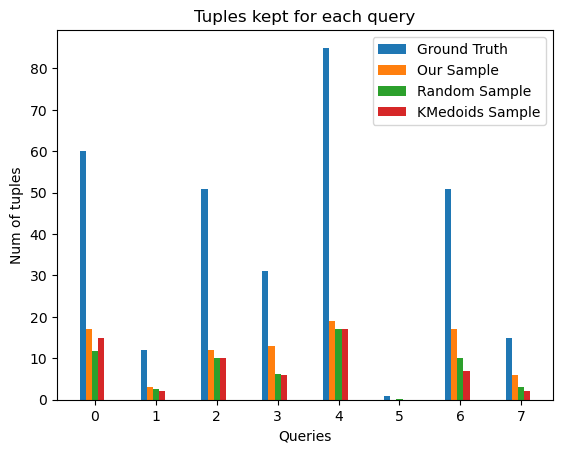

In [120]:
import pandasql as ps
import matplotlib.pyplot as plt

dataAccess = DataAccess()
queries = [q['sql'][0].replace("_id", "*") for q in workload]
x = [*range(len(queries))]

sampleY = []
randomY = []
kmedoidsY = []
truthY = []

# TODO: show num of tuples / 20 and change this to test set

for query in queries:
    sample_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "df"))
    kmedoids_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "df3"))
    truth_query_df = dataAccess.select_to_df(query)

    random_dfs = [DataAccess().select_to_df(f"SELECT * FROM {schema}.{table} ORDER BY RANDOM() LIMIT {saqp_manager.k}")
                  for i in range(numRandomTrials)]
    random_scores = []
    for random_df in random_dfs:
        random_query_df = ps.sqldf(query.replace(f"{schema}.{table}", "random_df"))
        random_scores += [len(random_query_df)]

    randomY += [(sum(random_scores) / numRandomTrials)]
    sampleY += [len(sample_query_df.index)]
    kmedoidsY += [len(kmedoids_query_df.index)]
    truthY += [len(truth_query_df.index)]

plt.bar([t - 0.2 for t in x], truthY, 0.1, label='Ground Truth')
plt.bar([t - 0.1 for t in x], sampleY, 0.1, label='Our Sample')
plt.bar([t for t in x], randomY, 0.1, label='Random Sample')
plt.bar([t + 0.1 for t in x], kmedoidsY, 0.1, label='K-medoids Sample')

plt.xlabel("Queries")
plt.ylabel("Num of tuples")
plt.title("Tuples kept for each query")
plt.legend()
plt.show()